# fMRI Dimensionality Reduction

## Introduction
fMRI analysis often has a dimensionality problem: we get approximately 100,000 voxels (features) per volume, but only 100s of time points or trials (examples). This makes it very hard for machine learning algorithms to model how each voxel contributes. This problem is dubbed the curse of dimensionality.

In this notebook we are going to explore several methods to reduce the dimensionality of complex fMRI data. 

## Goal of this Script
1. Learn to compute the covariance of a dataset.  
2. Reduce the feature space using principal component analysis (PCA).  
3. Interpret the meaning of PCA components.  
4. Perform feature selection using cross-validation.  

## Table of Contents
* [1. Load the Data](#load_data)  

* [2. Covariance](#covariance)  

* [3. PCA](#pca)  
    * [3.1 Plot PCA](#plot_pca)  
    * [3.2 "Scree" Plots](#scree)  
    * [3.3 Interpreting Components](#cog-relevance)  
    * [3.4 Normalization](#pca-norm)  
    * [3.5  PCA Dimensionality Reduction and Classification](#wb-pca-class)  


* [4. Feature Selection](#feat)  
    * [4.1 Feature Selection: Pipelines](#pipeline)  
    * [4.2 Feature Selection: Univariate](#univariate)   

* [Conclusion](#conclusion)

* [Contributions](#contributions)

**Dataset:** For this script we will use a localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017). 

The localizer consisted of 3 runs with 5 blocks of each category (faces, scenes and objects) per run. Each block was presented for 15s. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there was 15s (10 TRs) of fixation. Each run was 310 TRs. In the matlab stimulus file, the first row codes for the stimulus category for each trial (1 = Faces, 2 = Scenes, 3 = Objects). The 3rd row contains the time (in seconds, relative to the start of the run) when the stimulus was presented for each trial.


In [1]:
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Import neuroimaging, analysis and general libraries
import numpy as np
from time import time
import pandas as pd

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import cross_val_score, cross_validate, PredefinedSplit
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFECV, f_classif
from sklearn.pipeline import Pipeline

%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={'lines.linewidth': 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


In [2]:
# load some helper functions
from utils import load_labels, load_data, blockwise_sampling, label2TR, shift_timing, reshape_data
from utils import normalize, decode
# load some constants
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, vdc_hrf_lag, vdc_TR, vdc_TRs_run

print('Here\'re some constants, which is specific for VDC data:')
print('data dir = %s' % (vdc_data_dir))
print('ROIs = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('number of runs = %s' % (vdc_n_runs))
print('1 TR = %.2f sec' % (vdc_TR))
print('HRF lag = %.2f sec' % (vdc_hrf_lag))
print('num TRs per run = %d' % (vdc_TRs_run))

Here're some constants, which is specific for VDC data:
data dir = /Users/aratzan/Downloads/brainiak_datasets/vdc
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3
1 TR = 1.50 sec
HRF lag = 4.50 sec
num TRs per run = 310


## 1. Load the Data <a id="load_data"></a>

Load the data for one participant using helper functions.

In [3]:
sub_id = 1
mask_name = '' #can be 'FFA' or 'PPA'
# This is set in order to reduce memory demands in order to run within 4Gb, 
# however, if you want to make this run on whole brain, then set this to ''

In [4]:
# Specify the subject name
sub = 'sub-%.2d' % (sub_id)
# Convert the shift into TRs
shift_size = int(vdc_hrf_lag / vdc_TR)  

# Load subject labels
stim_label_allruns = load_labels(vdc_data_dir, sub)

# Load run_ids
run_ids_raw = stim_label_allruns[5,:] - 1 

# Load the fMRI data using a mask
epi_mask_data_all = load_data(vdc_data_dir, sub, mask_name=mask_name)[0]

# This can differ per participant
print(sub, '= TRs: ', epi_mask_data_all.shape[1], '; Voxels: ', epi_mask_data_all.shape[0])
TRs_run = int(epi_mask_data_all.shape[1] / vdc_n_runs)

# Convert the timing into TR indexes
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Perform the reshaping of the data
bold_data_raw, labels_raw = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

# Normalize raw data within each run
bold_normalized_raw = normalize(bold_data_raw, run_ids_raw)

# Down sample the data to be blockwise rather than trialwise. 
#We'll use the blockwise data for all the 
bold_data, labels, run_ids = blockwise_sampling(bold_data_raw, labels_raw, run_ids_raw)

# Normalize blockwise data within each run
bold_normalized = normalize(bold_data, run_ids)

Loaded  sub-01
Processing Start ...
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 = TRs:  930 ; Voxels:  177314
Expected blocks: 45; Resampled blocks: 45


## 2. Covariance <a id="covariance"></a>

To illustrate the building blocks behind dimensionality reduction we will calculate the whole brain covariance and correlation matrix. 

Memory demands can be reduced by implementing a mask on the data. There are nearly 1 million voxels in every volume acquired, of which about 15% are in the brain. The data matrix of >100,000 voxels and <1000 time points is very large, making any computations on all of this data very intensive.

The covariance of two variables is calculated as follows: $$ Cov(X,Y) = \frac{\sum_{1}^{N}(X-\bar{X})(Y-\bar{Y})}{(N-1)}$$
where $\mbox{  }  \bar{X} = mean(X), \mbox{  } \bar{Y} = mean(Y), \mbox{  } N = \mbox{number of samples } $

Here we compute the covariance between two blocks (i.e., their averaged patterns across voxels).
(reference: [here]( https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.cov.html))


In [5]:
print(bold_normalized.shape)

X = bold_normalized[2]
Y = bold_normalized[3]

print(np.cov(X, Y))


(45, 177314)
[[0.72974702 0.04715102]
 [0.04715102 0.7667193 ]]


Covariance is dependent on the unit and scale of the measurement. Its value is thus not easily interpretable or comparable across datasets -- e.g. is there a strong relationship between X and Y if the covariance is 200 as compared to 2 or 2000?

Correlation solves this problem by normalizing the range of the covariance from -1 to +1.

$$ Corr(X,Y) = \frac{Cov(X,Y)}{\sqrt{\frac{\sum_{1}^{N}(X-\bar{X})^2}{(N-1)}}\sqrt{\frac{\sum_{1}^{N}(Y-\bar{Y})^2}{(N-1)}}}$$

Compute the correlation between all pairs of blocks with a numpy function that calculates the block-by-block correlation matrix in one step.

In [6]:
print(np.corrcoef(bold_normalized))

[[ 1.         -0.08845684 -0.10432531 ... -0.0617117   0.00716105
   0.04060892]
 [-0.08845684  1.         -0.29326922 ...  0.05756334 -0.0574214
  -0.02382237]
 [-0.10432531 -0.29326922  1.         ... -0.02892532  0.05141131
   0.00837057]
 ...
 [-0.0617117   0.05756334 -0.02892532 ...  1.         -0.34035048
  -0.1573486 ]
 [ 0.00716105 -0.0574214   0.05141131 ... -0.34035048  1.
  -0.21931423]
 [ 0.04060892 -0.02382237  0.00837057 ... -0.1573486  -0.21931423
   1.        ]]


## 3. PCA <a id="pca"></a>

We will use principal component analysis (PCA) to **reduce the dimensionality** of the data. Some voxels may contain correlated information or no information and so the original voxel-dimensional data matrix (time-by-voxels) can be projected into a lower-dimensional "component" matrix space (time-by-component) without losing much information.

![image](https://cdn-images-1.medium.com/max/1200/1*Iri_LDMXuz2Qac-8KPeESA.png)

In [7]:
# Use the PCA function in scikit-learn to reduce the dimensionality of the data
# The number of components was chosen arbitrarily.
pca = PCA(n_components=20)
bold_pca = pca.fit_transform(bold_data) #5519 features --> 20 components
var= pca.explained_variance_ratio_

print('Original data shape:', bold_data.shape)
print('PCA data shape:', bold_pca.shape)

Original data shape: (45, 177314)
PCA data shape: (45, 20)


### 3.1 Plot PCA <a id="plot_pca"></a>

Let's visualize the variance in the data along different component dimensions.

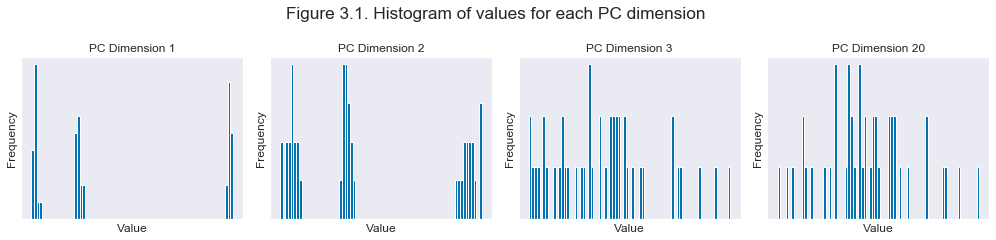

In [8]:
# Setting plotting parameter
n_bins=75

# Plot
n_plots = 4
components_to_plot = [0,1,2,19]
f, axes = plt.subplots(1, n_plots, figsize=(14, 14/n_plots))
st=f.suptitle("Figure 3.1. Histogram of values for each PC dimension ", fontsize="x-large")

for i in range(n_plots): 
    axes[i].hist(bold_pca[:, components_to_plot[i]], 
                 bins=n_bins)
    # mark the plots 
    axes[i].set_title('PC Dimension %d'%(components_to_plot[i]+1))
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Value')    
    axes[i].set_xticks([])
    axes[i].set_yticks([])    

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)


Let's visualize the relationship between variances across pairs of components.

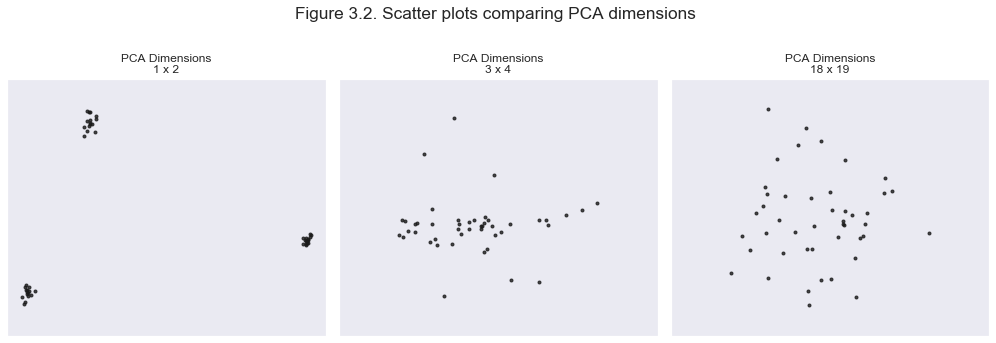

In [9]:
"""
Plot the low dim representation of the bold data
"""
# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# Plot
n_plots = 3 
f, axes = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="x-large")

# plot data
axes[0].scatter(bold_pca[:, 0], bold_pca[:, 1], 
                alpha=alpha_val, marker='.', color = 'k')
axes[1].scatter(bold_pca[:, 2], bold_pca[:, 3], 
                alpha=alpha_val, marker='.', color = 'k')
axes[2].scatter(bold_pca[:, 18], bold_pca[:, 19], 
                alpha=alpha_val, marker='.', color = 'k')

axes[0].set_title('PCA Dimensions\n1 x 2')
axes[1].set_title('PCA Dimensions\n3 x 4')
axes[2].set_title('PCA Dimensions\n18 x 19')

# modifications that are common to all plots 
for i in range(n_plots): 
    axes[i].axis('equal')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)


**Explanation:** As we can see, there is evident variance between some principal components and others not as much. 

This can help illustrate how many principal components explain the variance in the data... what are the defining features in low dimensionality. 

### 3.2 "Scree" Plots <a id="scree"></a>

A ["scree" plot](https://www.theanalysisfactor.com/factor-analysis-how-many-factors/) can depict the amount of variance in the original data that is explained by each component.

The scree plot below shows how many components would be sufficient to account for most of the variance. 

Text(0, 0.5, 'Eigenvalue')

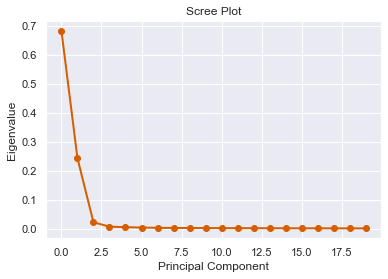

In [10]:
var = pca.explained_variance_ratio_ #use var instead of eignevalcount

plt.plot(np.arange(0, bold_pca.shape[1]), var, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

**Explanation:** This data shows that the first 2 principal components account for most of the variance in the data. This affirms the PCA dimensionality scatter plots. 

### 3.3 Interpreting Components  <a id="cog-relevance"></a>

Here we aim to attribute clusters to what they represent in the data. Let's have a look at what the PCA 1x2 plot clusters truly represent. 

**Scatter Plot 1:**  Principal Component 1 x Principal Component 2 with labels color coded. 

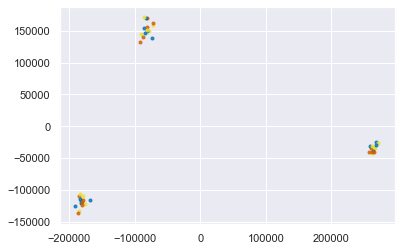

In [11]:
"""
Plot the low dim representation of the bold data
"""
from matplotlib  import cm
# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# plot pca vals of each run with different color based on their label 
# PCA 1 and 2 for all rows 
 
# separate scatters by label 
for i in range(len(labels)):
    if labels[i] == 1: #faces
        plt.scatter(bold_pca[i, 0], bold_pca[i, 1],
                alpha=alpha_val, marker='.', color = 'r')
    elif labels[i] == 2: #scenes 
        plt.scatter(bold_pca[i, 0], bold_pca[i, 1],
                alpha=alpha_val, marker='.', color = 'y')
    else: #objects 
        plt.scatter(bold_pca[i, 0], bold_pca[i, 1],
                alpha=alpha_val, marker='.', color = 'b')

plt.show()

15
30
45


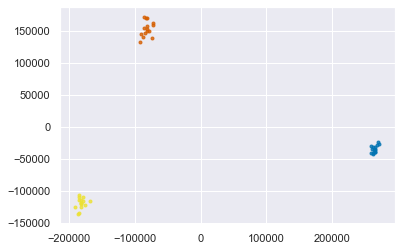

In [12]:
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

#figure out how to separate scatters by run id  
i = 0
while i < len(run_ids):
    i+=15
    color = 'r'
    print(i)
    if i > 30:
        color = 'b'
    elif i > 15:
        color = 'y'
    plt.scatter(bold_pca[i-15:i, 0], bold_pca[i-15:i, 1], alpha=alpha_val, marker='.', color = color)
    
plt.show()

#split up by run, likely shows that runs were not all metrically equal 

**Explanation:** The results of these plots show that between runs the fMRI data may not be metrically consistent. Bold data differs more due to run id rather than label. Below we will see methods that can be used to still classify bold data by label. 

### 3.4 Normalization <a id="pca-norm"></a>

Previously we ran the PCA analysis without normalizing the data.

The previous PCA was ran on bold_data. Here we will apply PCA on the same data after applying normalization. 

[0.20894986 0.06794341 0.05489049 0.04346689 0.03751845 0.03053131
 0.02996581 0.02685036 0.02583195 0.02503488 0.02296694 0.02158888
 0.02007598 0.01929076 0.01890483 0.01833781 0.01659148 0.01633347
 0.01630362 0.01516502]


Text(0, 0.5, 'Eigenvalue')

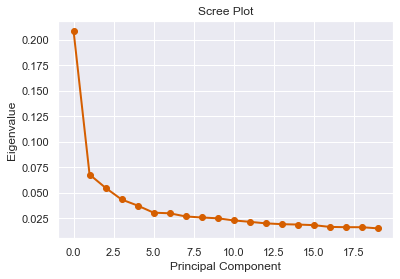

In [14]:
pca = PCA(n_components=20)
bold_pca = pca.fit_transform(bold_normalized)

var = pca.explained_variance_ratio_ 
print(var)

plt.plot(np.arange(0, bold_pca.shape[1]), var, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')


Scree plot looks similar, although this doesn't indicate similarity in what the principal components represent. 

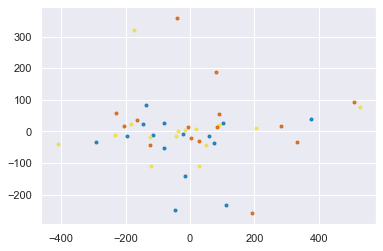

In [15]:
from matplotlib  import cm
# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)

# plot pca vals of each run with different color based on their label 
# PCA 1 and 2 for all rows 
 
# separate scatters by label 
for i in range(len(labels)):
    if labels[i] == 1: #faces
        plt.scatter(bold_pca[i, 0], bold_pca[i, 1],
                alpha=alpha_val, marker='.', color = 'r')
    elif labels[i] == 2: #scenes 
        plt.scatter(bold_pca[i, 0], bold_pca[i, 1],
                alpha=alpha_val, marker='.', color = 'y')
    else: #objects 
        plt.scatter(bold_pca[i, 0], bold_pca[i, 1],
                alpha=alpha_val, marker='.', color = 'b')

plt.show()

No evident clustering indicates the first 2 principal components may not be enough to explain the data. 

### 3.5 PCA Dimensionality Reduction and Classification <a id="wb-pca-class"></a>

Test some classifiers on dimensionalty reduced data .

In [16]:
# Run a basic n-fold classification

# Get baseline, whole-brain decoding accuracy without PCA
print('Baseline classification')
print('Original size: ', bold_normalized.shape)
svc = SVC(kernel="linear", C=1)

start = time()
models, scores = decode(bold_normalized, labels, run_ids, svc)
end = time()
print('Accuracy: ', scores)
print('Run time: %0.4fs' %(end - start))

Baseline classification
Original size:  (45, 177314)
Accuracy:  [0.8, 0.9333333333333333, 0.8]
Run time: 1.3301s


In [17]:
# Run the classifier on data in component space 
pca = PCA(n_components=20)
bold_pca_normalized = pca.fit_transform(bold_normalized)
print('PCA (c=%d) classification' % bold_pca_normalized.shape[1])
print('New size after PCA: ', bold_pca_normalized.shape)

start = time()
models_pca, scores_pca = decode(bold_pca_normalized, labels, run_ids, svc)
end = time()
print('Accuracy: ', scores_pca)
print('Run time: %0.4fs' %(end - start))

PCA (c=20) classification
New size after PCA:  (45, 20)
Accuracy:  [0.8666666666666667, 0.8666666666666667, 0.7333333333333333]
Run time: 0.0059s


**Explanation:** In this case PCA does not greatly alter decoding accuracy. **However, note that similar performance was achieved with 20 vs. 177,314 features, that the analysis ran 300-500x faster, and that the resulting model is likely to generalize better to new data (e.g., from a different subject).**

Now, test how the number of components affects the accuracy of classifiers. 

In [19]:
pca = PCA(n_components=14)
bold_pca_normalized = pca.fit_transform(bold_normalized)
print('PCA (c=%d) classification' % bold_pca_normalized.shape[1])
print('New size after PCA: ', bold_pca_normalized.shape)

start = time()
models_pca, scores_pca = decode(bold_pca_normalized, labels, run_ids, svc)
end = time()
print('Accuracy: ', scores_pca)
print('Run time: %0.4fs' %(end - start))

#4 components is enough for this example 

PCA (c=14) classification
New size after PCA:  (45, 14)
Accuracy:  [0.9333333333333333, 1.0, 0.9333333333333333]
Run time: 0.0035s


**Explanation:** Around 14 principal components are required for a high quality classifier. 5 principal components or more will give better than random accuracy. 

## 4. Feature Selection Using Cross-Validation <a id="feat"></a>

By taking a few PCA components instead of all voxels, a form of feature selection is being performed. Feature selection is used to reduce noise and increase computational speed. A problem with the approach above is that feature selection is applied to all data (prior to division into training and test sets) and is thus a kind of double dipping.

A better way to select features is during cross-validation. In this case, feature selection is only performed on the training set, and the same features are used on the test data. This way the classifier never sees the test data during training.

We will perform feature selection during cross-validation in this section. 



### 4.1 Pipelines: Feature selection with cross-validation  <a id="pipeline"></a>

Below we create a pipeline using scikit learn with the following steps:
  
>1. Perform dimensionality reduction.  
>2. Run an SVM.

To do this systematically during cross-validation, we will embed `Pipeline` in the `cross_validate` method in scikit-learn.

In [24]:
# Set up the pipeline
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=14)),
    ('classify', SVC(kernel="linear", C=1)),
])

# Run the pipeline with cross-validation
ps = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe = cross_validate(
    pipe,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

{'fit_time': array([0.5044291 , 0.49418616, 0.532938  ]), 'score_time': array([0.01365495, 0.01562595, 0.01435637]), 'test_score': array([0.6       , 0.66666667, 0.66666667]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.64


**Result:** Using a pipeline with dimensionality reduction and cross-validation embedded with 14 components the accuracy of the classifier is approximately 65%. 


### 4.2 Feature Selection: Univariate <a id="univariate"></a>

We can also use a variety of univariate methods to do feature selection in scikit-learn. One commonly used technique is to compute an ANOVA on the data and pick voxels with large F values. The F value measures the ratio of the variance between conditions (signal) to the variance within condition (noise). 

Implement the pipeline using ANOVA F-value (imported as `f_classif`) and the [`SelectKBest` method](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) pick the top 100 voxels with the highest F values.

In [25]:
from sklearn.feature_selection import SelectKBest, chi2
# Insert code
pipe = Pipeline([
    ('reduce_dim', SelectKBest(k=100)),
    ('classify', SVC(kernel="linear", C=1)),
])

# Run the pipeline with cross-validation
ps = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe = cross_validate(
    pipe,bold_normalized,labels,cv=ps,
    return_train_score=True
)

print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

#selectKbest gives 98% accuracy 

{'fit_time': array([0.16581917, 0.11724329, 0.11866498]), 'score_time': array([0.0217979 , 0.02082467, 0.02162695]), 'test_score': array([1., 1., 1.]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 1.00


**Explanation:** As can be seen in the above cell using the top 100 features with the highest F-values (SelectKBest) provides a much stronger classifier than the cross-validated PCA with 20 components. 

## Conclusion  <a id="conclusion"></a>
PCA and other dimensionality reduction/feature selection can be used on the face, scene, object recognition dataset. While the classification accuracies might be marginally lower there is a positive tradeoff with the amount of time these methods take making them viable application for larger, more complex datasets. 

## Contributions <a id="contributions"></a>

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook  02/2018  
T. Meissner minor edits and added the ICA section  
Q. Lu revise PCA plots, cb colors, code style improvement, leverage exisiting funcs  
H. Zhang added pipeline section, use blockwise normalized data, other edits  
M. Kumar enhanced section introductions.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented comments from cmhn-s19